<a href="https://colab.research.google.com/github/jackpal/colabraytracing/blob/master/Toy_Path_Tracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Swift Colab version of [Toy Path Tracer](https://github.com/aras-p/ToyPathTracer).

This is a straight port based on the C# version.

In [1]:
// Setup. (Must be in its own cell because of https://bugs.swift.org/browse/TF-183).
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


Define some helper functions.

In [0]:
import Python

let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

# Math


In [0]:
struct MathF {
  static func Abs(_ f: Float) -> Float { f.magnitude }
  static func Sqrt(_ f : Float) -> Float { f.squareRoot() }
  static func Max(_ a: Float, _ b: Float) -> Float { max(a, b) }
  static func Sin(_ f : Float) -> Float { Float.sin(f) }
  static func Cos(_ f : Float) -> Float { Float.cos(f) }
  static func Tan(_ f : Float) -> Float { Float.tan(f) }
}

public struct float3
{
    public var x: Float
    public var y: Float
    public var z: Float

    public init(_ x_ : Float, _ y_ : Float, _ z_ : Float) { x = x_; y = y_; z = z_; }
    public var SqLength : Float { x * x + y * y + z * z }
    public var Length : Float { MathF.Sqrt(x * x + y * y + z * z) }
    public mutating func Normalize() {
      let k = 1.0 / Length
      x *= k
      y *= k
      z *= k
    }
}

public func +=(lhs: inout float3, rhs: float3) {
  lhs.x += rhs.x
  lhs.y += rhs.y
  lhs.z += rhs.z
}

public func *=(lhs: inout float3, rhs: Float) {
  lhs.x *= rhs
  lhs.y *= rhs
  lhs.z *= rhs
}

public func +(_ a : float3, _ b : float3) -> float3 { float3(a.x + b.x, a.y + b.y, a.z + b.z) }
public func -(_ a : float3, _ b : float3) -> float3 { float3(a.x - b.x, a.y - b.y, a.z - b.z) }
public func *(_ a : float3, _ b : float3) -> float3 { float3(a.x * b.x, a.y * b.y, a.z * b.z) }
public func *(_ a : float3, _ b : Float) -> float3 { float3(a.x * b, a.y * b, a.z * b) }
public func *(_ a : Float, _ b : float3) -> float3 { float3(a * b.x, a * b.y, a * b.z) }
public prefix func -(_ a : float3) -> float3 { float3(-a.x, -a.y, -a.z) }

extension float3 {
    public static func Dot(_ a : float3, _ b : float3) -> Float { a.x * b.x + a.y * b.y + a.z * b.z }
    public static func Cross(_ a : float3, _ b : float3) -> float3 { float3(a.y * b.z - a.z * b.y, -(a.x * b.z - a.z * b.x), a.x * b.y - a.y * b.x) }
    public static func Normalize(_ v : float3) -> float3 {
      let k = 1.0 / v.Length
      return float3(v.x * k, v.y * k, v.z * k)
    }

    public var IsNormalized : Bool { (SqLength - 1.0).magnitude < 0.01 }

    public static func Reflect(_ v: float3, _ n: float3) -> float3
    {
        assert(v.IsNormalized)
        return v - 2 * Dot(v, n) * n
    }

    public static func Refract(_ v: float3, _ n: float3, _ nint: Float, _ outRefracted: inout float3) -> Bool
    {
        assert(v.IsNormalized)
        let dt = Dot(v, n)
        let discr = 1.0 - nint * nint * (1 - dt * dt)
        if (discr > 0)
        {
            outRefracted = nint * (v - n * dt) - n * MathF.Sqrt(discr)
            assert(outRefracted.IsNormalized)
            return true
        }
        outRefracted = float3(0, 0, 0)
        return false
    }
}

extension float3 {
  static let zero = float3(0,0,0)
}

public enum MathUtil
{
    public static let PI = Float.pi

    public static func Schlick(_ cosine: Float, _ ri: Float) -> Float
    {
        var r0 = (1 - ri) / (1 + ri)
        r0 = r0 * r0
        return r0 + (1 - r0) * Float.pow(1 - cosine, 5)
    }

    // A simple pseudorandom sequence generator.
    static func XorShift32(_ state: inout UInt32) -> UInt32
    {
        var x = state
        x ^= x << 13
        x ^= x >> 17
        x ^= x << 15
        state = x
        return x
    }

    // [MethodImpl(MethodImplOptions.AggressiveInlining)]
    public static func RandomFloat01(_ state: inout UInt32) -> Float
    {
        return Float(XorShift32(&state) & 0xFFFFFF) / 16777216.0
    }

    public static func RandomInUnitDisk(_ state: inout UInt32) -> float3
    {
        var p: float3
        repeat
        {
            p = 2.0 * float3(RandomFloat01(&state), RandomFloat01(&state), 0)
              - float3(1, 1, 0)
        } while p.SqLength >= 1.0
        return p
    }

    public static func RandomInUnitSphere(_ state: inout UInt32) -> float3
    {
        var p: float3
        repeat
        {
            p = 2.0 * float3(RandomFloat01(&state),
             RandomFloat01(&state),
             RandomFloat01(&state)) - float3(1, 1, 1)
        } while p.SqLength >= 1.0
        return p
    }

    public static func RandomUnitVector(_ state: inout UInt32) -> float3
    {
        let z = RandomFloat01(&state) * 2.0 - 1.0
        let a = RandomFloat01(&state) * 2.0 * PI
        let r = MathF.Sqrt(1.0 - z * z)
        let x = MathF.Sin(a)
        let y = MathF.Cos(a)
        return float3(r * x, r * y, z)
    }

}

public struct Ray
{
    public var orig: float3
    public var dir: float3

    public init() {
      self.init(.zero, float3(0,0,1))
    }

    public init(_ orig_ : float3, _ dir_ : float3)
    {
        assert(dir_.IsNormalized, "dir must be normalized.")
        orig = orig_
        dir = dir_
    }

    public func PointAt(_ t: Float) -> float3 { orig + dir * t }
}

public struct Hit
{
    public var pos: float3
    public var normal: float3
    public var t: Float

    public init() {
      self.init(.zero, .zero, 0)
    }

    public init(_ pos: float3, _ normal: float3, _ t: Float) {
      self.pos = pos
      self.normal = normal
      self.t = t
    }
}

public struct Sphere
{
    public var center: float3
    public var radius: Float
    public init(_ center_: float3, _ radius_: Float) {
      center = center_
      radius = radius_
    }
}

struct Material
{
  public enum `Type` {
    case Lambert
    case Metal
    case Dielectric
  }

  public var type: `Type`
  public var albedo: float3
  public var emissive: float3
  public var roughness: Float
  public var ri: Float

  public init(_ t: Type, _ a: float3, _ e: float3, _ r: Float, _ i: Float)
  {
    type = t
    albedo = a
    emissive = e
    roughness = r
    ri = i
  }

  public var HasEmission : Bool {
    emissive.x > 0 || emissive.y > 0 || emissive.z > 0
  }
}

struct SpheresSoA
{
    public var centerX: [Float]
    public var centerY: [Float]
    public var centerZ: [Float]
    public var sqRadius: [Float]
    public var invRadius: [Float]
    public var emissives: [Int]
    public var emissiveCount: Int

    public init(_ len: Int)
    {
        centerX = [Float](repeating: 0.0, count:len)
        centerY = [Float](repeating: 0.0, count:len)
        centerZ = [Float](repeating: 0.0, count:len)
        sqRadius = [Float](repeating: 0.0, count:len)
        invRadius = [Float](repeating: 0.0, count:len)
        emissives = [Int](repeating: 0, count:len)
        emissiveCount = 0
    }

    public mutating func Update(_ src: [Sphere], _ mat: [Material])
    {
        emissiveCount = 0
        for i in 0..<src.count
        {
            let s = src[i]
            centerX[i] = s.center.x
            centerY[i] = s.center.y
            centerZ[i] = s.center.z
            sqRadius[i] = s.radius * s.radius
            invRadius[i] = 1.0 / s.radius
            if mat[i].HasEmission
            {
                emissives[emissiveCount] = i
                emissiveCount += 1
            }
        }
    }

    // Returns the ID of the sphere that is hit, or -1 if no spheres are hit. 
    public func HitSpheres(_ r: Ray, _ tMin: Float, _ tMax: Float, _ outHit : inout Hit) -> Int
    {
        var hitT = tMax
        var id = -1
        for i in 0..<centerX.count
        {
            let coX = centerX[i] - r.orig.x
            let coY = centerY[i] - r.orig.y
            let coZ = centerZ[i] - r.orig.z
            let nb = coX * r.dir.x + coY * r.dir.y + coZ * r.dir.z
            let c = coX * coX + coY * coY + coZ * coZ - sqRadius[i]
            let discr = nb * nb - c
            if discr > 0
            {
                let discrSq = MathF.Sqrt(discr)

                // Try earlier t
                var t = nb - discrSq
                if (t <= tMin) { // before min, try later t!
                    t = nb + discrSq
                }

                if (t > tMin && t < hitT)
                {
                    id = i;
                    hitT = t;
                }
            }
        }
        if id != -1
        {
            outHit.pos = r.PointAt(hitT)
            outHit.normal = (outHit.pos - float3(centerX[id], centerY[id], centerZ[id])) * invRadius[id]
            outHit.t = hitT
            return id
        }
        else {
            return -1
        }
    }
}

struct Camera
{
    // vfov is top to bottom in degrees
    public init(_ lookFrom: float3, _ lookAt: float3, _ vup: float3,
      _ vfov: Float, _ aspect: Float, _ aperture: Float, _ focusDist: Float)
    {
        lensRadius = aperture / 2
        let theta = vfov * MathUtil.PI / 180
        let halfHeight = MathF.Tan(theta / 2)
        let halfWidth = aspect * halfHeight
        origin = lookFrom
        w = float3.Normalize(lookFrom - lookAt)
        u = float3.Normalize(float3.Cross(vup, w))
        v = float3.Cross(w, u)
        lowerLeftCorner = origin - halfWidth*focusDist*u - halfHeight*focusDist*v - focusDist*w
        horizontal = 2*halfWidth * focusDist*u
        vertical = 2*halfHeight * focusDist*v
    }

    public func GetRay(_ s: Float, _ t: Float, _ state: inout UInt32) -> Ray
    {
        let rd = lensRadius * MathUtil.RandomInUnitDisk(&state)
        let offset = u * rd.x + v * rd.y
        return Ray(origin + offset, float3.Normalize(lowerLeftCorner + s*horizontal + t*vertical - origin - offset))
    }
    
    var origin : float3
    var lowerLeftCorner : float3
    var horizontal : float3
    var vertical : float3
    var u : float3
    var v : float3
    var w : float3
    var lensRadius : Float
}

Test


In [0]:
var DO_ANIMATE = false
var DO_LIGHT_SAMPLING = true
var DO_THREADED = true
// 46 spheres (2 emissive) when enabled; 9 spheres (1 emissive) when disabled
var DO_BIG_SCENE = true

struct Scene {
  var spheres: [Sphere]
  var materials: [Material]
}

func createScene(doBigScene: Bool) -> Scene {
  func spheres() -> [Sphere] {
    var result = [
      Sphere(float3(0,-100.5,-1), 100),
      Sphere(float3(2,0,-1), 0.5),
      Sphere(float3(0,0,-1), 0.5),
        Sphere(float3(-2,0,-1), 0.5),
        Sphere(float3(2,0,1), 0.5),
        Sphere(float3(0,0,1), 0.5),
        Sphere(float3(-2,0,1), 0.5),
        Sphere(float3(0.5,1,0.5), 0.5),
        Sphere(float3(-1.5,1.5,0), 0.3)
    ]
    if doBigScene {
      result = result + [
        Sphere(float3(4,0,-3), 0.5), Sphere(float3(3,0,-3), 0.5), Sphere(float3(2,0,-3), 0.5), Sphere(float3(1,0,-3), 0.5), Sphere(float3(0,0,-3), 0.5), Sphere(float3(-1,0,-3), 0.5), Sphere(float3(-2,0,-3), 0.5), Sphere(float3(-3,0,-3), 0.5), Sphere(float3(-4,0,-3), 0.5),
        Sphere(float3(4,0,-4), 0.5), Sphere(float3(3,0,-4), 0.5), Sphere(float3(2,0,-4), 0.5), Sphere(float3(1,0,-4), 0.5), Sphere(float3(0,0,-4), 0.5), Sphere(float3(-1,0,-4), 0.5), Sphere(float3(-2,0,-4), 0.5), Sphere(float3(-3,0,-4), 0.5), Sphere(float3(-4,0,-4), 0.5),
        Sphere(float3(4,0,-5), 0.5), Sphere(float3(3,0,-5), 0.5), Sphere(float3(2,0,-5), 0.5), Sphere(float3(1,0,-5), 0.5), Sphere(float3(0,0,-5), 0.5), Sphere(float3(-1,0,-5), 0.5), Sphere(float3(-2,0,-5), 0.5), Sphere(float3(-3,0,-5), 0.5), Sphere(float3(-4,0,-5), 0.5),
        Sphere(float3(4,0,-6), 0.5), Sphere(float3(3,0,-6), 0.5), Sphere(float3(2,0,-6), 0.5), Sphere(float3(1,0,-6), 0.5), Sphere(float3(0,0,-6), 0.5), Sphere(float3(-1,0,-6), 0.5), Sphere(float3(-2,0,-6), 0.5), Sphere(float3(-3,0,-6), 0.5), Sphere(float3(-4,0,-6), 0.5),
        Sphere(float3(1.5,1.5,-2), 0.3)
      ]
    }
    return result
  }

  func materials() -> [Material] {
    var result = [
      Material(.Lambert,     float3(0.8, 0.8, 0.8), float3(0,0,0), 0, 0),
      Material(.Lambert,     float3(0.8, 0.4, 0.4), float3(0,0,0), 0, 0),
      Material(.Lambert,     float3(0.4, 0.8, 0.4), float3(0,0,0), 0, 0),
      Material(.Metal,       float3(0.4, 0.4, 0.8), float3(0,0,0), 0, 0),
      Material(.Metal,       float3(0.4, 0.8, 0.4), float3(0,0,0), 0, 0),
      Material(.Metal,       float3(0.4, 0.8, 0.4), float3(0,0,0), 0.2, 0),
      Material(.Metal,       float3(0.4, 0.8, 0.4), float3(0,0,0), 0.6, 0),
      Material(.Dielectric,  float3(0.4, 0.4, 0.4), float3(0,0,0), 0, 1.5),
      Material(.Lambert,     float3(0.8, 0.6, 0.2), float3(30,25,15), 0, 0)
    ]
    if doBigScene {
      result = result + [
        Material(.Lambert, float3(0.1, 0.1, 0.1), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.2, 0.2, 0.2), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.3, 0.3, 0.3), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.4, 0.4, 0.4), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.5, 0.5, 0.5), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.6, 0.6, 0.6), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.7, 0.7, 0.7), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.8, 0.8, 0.8), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.9, 0.9, 0.9), float3(0,0,0), 0, 0),
        Material(.Metal, float3(0.1, 0.1, 0.1), float3(0,0,0), 0, 0), Material(.Metal, float3(0.2, 0.2, 0.2), float3(0,0,0), 0, 0), Material(.Metal, float3(0.3, 0.3, 0.3), float3(0,0,0), 0, 0), Material(.Metal, float3(0.4, 0.4, 0.4), float3(0,0,0), 0, 0), Material(.Metal, float3(0.5, 0.5, 0.5), float3(0,0,0), 0, 0), Material(.Metal, float3(0.6, 0.6, 0.6), float3(0,0,0), 0, 0), Material(.Metal, float3(0.7, 0.7, 0.7), float3(0,0,0), 0, 0), Material(.Metal, float3(0.8, 0.8, 0.8), float3(0,0,0), 0, 0), Material(.Metal, float3(0.9, 0.9, 0.9), float3(0,0,0), 0, 0),
        Material(.Metal, float3(0.8, 0.1, 0.1), float3(0,0,0), 0, 0), Material(.Metal, float3(0.8, 0.5, 0.1), float3(0,0,0), 0, 0), Material(.Metal, float3(0.8, 0.8, 0.1), float3(0,0,0), 0, 0), Material(.Metal, float3(0.4, 0.8, 0.1), float3(0,0,0), 0, 0), Material(.Metal, float3(0.1, 0.8, 0.1), float3(0,0,0), 0, 0), Material(.Metal, float3(0.1, 0.8, 0.5), float3(0,0,0), 0, 0), Material(.Metal, float3(0.1, 0.8, 0.8), float3(0,0,0), 0, 0), Material(.Metal, float3(0.1, 0.1, 0.8), float3(0,0,0), 0, 0), Material(.Metal, float3(0.5, 0.1, 0.8), float3(0,0,0), 0, 0),
        Material(.Lambert, float3(0.8, 0.1, 0.1), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.8, 0.5, 0.1), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.8, 0.8, 0.1), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.4, 0.8, 0.1), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.1, 0.8, 0.1), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.1, 0.8, 0.5), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.1, 0.8, 0.8), float3(0,0,0), 0, 0), Material(.Lambert, float3(0.1, 0.1, 0.8), float3(0,0,0), 0, 0), Material(.Metal, float3(0.5, 0.1, 0.8), float3(0,0,0), 0, 0),
        Material(.Lambert, float3(0.1, 0.2, 0.5), float3(3,10,20), 0, 0),
      ]
    }
    return result
  }
  
  return Scene(spheres:spheres(), materials:materials())
}

struct Test
{
    var DO_SAMPLES_PER_PIXEL = 4
    var DO_ANIMATE_SMOOTHING: Float = 0.5

    var scene = createScene(doBigScene: DO_BIG_SCENE)   

    var s_SpheresSoA: SpheresSoA

    public init()
    {
        s_SpheresSoA = SpheresSoA(scene.spheres.count)
    }

    let kMinT: Float = 0.001
    let kMaxT: Float = 1.0e7
    let kMaxDepth = 10

    func HitWorld(_ r: Ray, _ tMin: Float, _ tMax: Float, _ outHit: inout Hit, _ outID: inout Int) -> Bool
    {
        outID = s_SpheresSoA.HitSpheres(r, tMin, tMax, &outHit)
        return outID != -1
    }

    func Scatter(_ mat: Material, _ r_in: Ray, _ rec: Hit, _ attenuation: inout float3,
       _  scattered: inout Ray, _ outLightE:inout float3, _ inoutRayCount: inout Int, _ state: inout UInt32) -> Bool
    {
        outLightE = float3(0, 0, 0)
        if (mat.type == .Lambert)
        {
            // random point inside unit sphere that is tangent to the hit point
            let target = rec.pos + rec.normal + MathUtil.RandomUnitVector(&state)
            scattered = Ray(rec.pos, float3.Normalize(target - rec.pos))
            attenuation = mat.albedo

            // sample lights
            if DO_LIGHT_SAMPLING {
              for j in 0..<s_SpheresSoA.emissiveCount
              {
                  let i = s_SpheresSoA.emissives[j]
                  let sphereMat = scene.materials[i]
                  //@TODO if (&mat == &smat)
                  //    continue // skip self
                  let s = scene.spheres[i]

                  // create a random direction towards sphere
                  // coord system for sampling: sw, su, sv
                  let sw = float3.Normalize(s.center - rec.pos)
                  let su = float3.Normalize(float3.Cross(MathF.Abs(sw.x) > 0.01 ? float3(0, 1, 0) : float3(1, 0, 0), sw))
                  let sv = float3.Cross(sw, su)
                  // sample sphere by solid angle
                  let cosAMax = MathF.Sqrt(MathF.Max(0.0, 1.0 - s.radius * s.radius / (rec.pos - s.center).SqLength))
                  let eps1 = MathUtil.RandomFloat01(&state)
                  let eps2 = MathUtil.RandomFloat01(&state)
                  let cosA = 1.0 - eps1 + eps1 * cosAMax
                  let sinA = MathF.Sqrt(1.0 - cosA * cosA)
                  let phi = 2 * MathUtil.PI * eps2
                  let l = su * MathF.Cos(phi) * sinA + sv * MathF.Sin(phi) * sinA + sw * cosA

                  // shoot shadow ray
                  var lightHit = Hit()
                  var hitID = 0
                  inoutRayCount += 1
                  let ray = Ray(rec.pos, l)
                  if HitWorld(ray, kMinT, kMaxT, &lightHit, &hitID) && hitID == i
                  {
                      let omega = 2 * MathUtil.PI * (1 - cosAMax)

                      let rdir = r_in.dir
                      assert(rdir.IsNormalized)
                      let nl = float3.Dot(rec.normal, rdir) < 0 ? rec.normal : -rec.normal
                      outLightE += (mat.albedo * sphereMat.emissive) * (MathF.Max(0.0, float3.Dot(l, nl)) * omega / MathUtil.PI)
                  }
              }
            } // DO_LIGHT_SAMPLING
            return true
        }
        else if mat.type == .Metal
        {
            assert(r_in.dir.IsNormalized)
            assert(rec.normal.IsNormalized)
            let refl = float3.Reflect(r_in.dir, rec.normal)
            // reflected ray, and random inside of sphere based on roughness
            scattered = Ray(rec.pos, float3.Normalize(refl + mat.roughness * MathUtil.RandomInUnitSphere(&state)))
            attenuation = mat.albedo
            return float3.Dot(scattered.dir, rec.normal) > 0
        }
        else if mat.type == .Dielectric
        {
            assert(r_in.dir.IsNormalized)
            assert(rec.normal.IsNormalized)
            var outwardN: float3
            let rdir = r_in.dir
            let refl = float3.Reflect(rdir, rec.normal)
            var nint: Float
            attenuation = float3(1, 1, 1)
            var refr : float3 = .zero
            var reflProb : Float
            var cosine : Float
            if float3.Dot(rdir, rec.normal) > 0
            {
                outwardN = -rec.normal
                nint = mat.ri
                cosine = mat.ri * float3.Dot(rdir, rec.normal)
            }
            else
            {
                outwardN = rec.normal
                nint = 1.0 / mat.ri
                cosine = -float3.Dot(rdir, rec.normal)
            }
            if float3.Refract(rdir, outwardN, nint, &refr)
            {
                reflProb = MathUtil.Schlick(cosine, mat.ri)
            }
            else
            {
                reflProb = 1
            }
            if MathUtil.RandomFloat01(&state) < reflProb {
                scattered = Ray(rec.pos, float3.Normalize(refl))
            } else {
                scattered = Ray(rec.pos, float3.Normalize(refr))
            }
        }
        else
        {
            attenuation = float3(1, 0, 1)
            scattered = Ray()
            return false
        }
        return true
    }

    // [MethodImpl(MethodImplOptions.AggressiveInlining)]
    func Trace(_ r: Ray, _ depth: Int, _ inoutRayCount: inout Int, _ state: inout UInt32, _ doMaterialE : Bool = true)-> float3
    {
        var rec = Hit()
        var id = 0
        inoutRayCount += 1
        if HitWorld(r, kMinT, kMaxT, &rec, &id)
        {
            var scattered = Ray()
            var attenuation = float3.zero
            var lightE = float3.zero
            let mat = scene.materials[id]
            var matE = mat.emissive
            if depth < kMaxDepth && Scatter(mat, r, rec, &attenuation, &scattered, &lightE, &inoutRayCount, &state)
            {
              var doMaterialERecursive = doMaterialE
              if DO_LIGHT_SAMPLING {
                if !doMaterialE {
                  matE = float3(0, 0, 0)
                }
                doMaterialERecursive = (mat.type != .Lambert)
              }
              return matE + lightE + attenuation * Trace(scattered, depth + 1, &inoutRayCount, &state, doMaterialERecursive)
            }
            else
            {
                return matE
            }
        }
        else
        {
            // sky
            let unitDir = r.dir
            let t = 0.5 * (unitDir.y + 1.0)
            return ((1.0 - t) * float3(1.0, 1.0, 1.0) + t * float3(0.5, 0.7, 1.0)) * 0.3
        }
    }

    func TraceRowJob(_ y: Int, _ screenWidth: Int, _ screenHeight: Int, _ frameCount :Int, _ pixelStride: Int, _ backbuffer: inout [Float], _ cam: Camera) -> Int
    {
        var backbufferIdx = y * screenWidth * pixelStride
        let invWidth = Float(1.0) / Float(screenWidth)
        let invHeight = Float(1.0) / Float(screenHeight)
        var lerpFac = Float(frameCount) / Float(frameCount + 1)
        if DO_ANIMATE {
          lerpFac *= DO_ANIMATE_SMOOTHING
        }
        var rayCount: Int = 0
        //for (uint32_t y = start y < end ++y)
        // {
            var state = UInt32(y * 9781 + frameCount * 6271) | 1
            for x in 0..<screenWidth
            {
                var col = float3(0, 0, 0)
                for _ in 0..<DO_SAMPLES_PER_PIXEL
                {
                    let u = (Float(x) + MathUtil.RandomFloat01(&state)) * invWidth
                    let v = (Float(y) + MathUtil.RandomFloat01(&state)) * invHeight
                    let r = cam.GetRay(u, v, &state)
                    col += Trace(r, 0, &rayCount, &state)
                }
                col *= 1.0 / Float(DO_SAMPLES_PER_PIXEL)

                let bbr = backbuffer[backbufferIdx + 0]
                let bbg = backbuffer[backbufferIdx + 1]
                let bbb = backbuffer[backbufferIdx + 2]

                let prev = float3(bbr, bbg, bbb)
                col = prev * lerpFac + col * (1 - lerpFac)
                backbuffer[backbufferIdx + 0] = col.x
                backbuffer[backbufferIdx + 1] = col.y
                backbuffer[backbufferIdx + 2] = col.z
                backbufferIdx += pixelStride
            }
        // }
        return rayCount
    }


    public mutating func DrawTest(_ time: Float, _ frameCount: Int, _ screenWidth: Int, _ screenHeight: Int, _ pixelStride: Int, _ backbuffer: inout [Float], _ outRayCount: inout Int)
    {
        var rayCount = 0
        if DO_ANIMATE {
          // TODO: Can we do this somewhere else and make DrawText non mutating?
          scene.spheres[1].center.y = MathF.Cos(time)+1.0
          scene.spheres[8].center.z = MathF.Sin(time)*0.3
        }
        let lookfrom = float3(0, 2, 3)
        let lookat = float3(0, 0, 0)
        let distToFocus: Float = 3
        var aperture: Float = 0.1
        if DO_BIG_SCENE {
          aperture *= 0.2
        }

        s_SpheresSoA.Update(scene.spheres, scene.materials)

        let cam = Camera(lookfrom, lookat, float3(0, 1, 0), 60, Float(screenWidth) / Float(screenHeight), aperture, distToFocus)

//#if DO_THREADED
//        Parallel.For<int>(0, screenHeight,
//                          () => 0,
//                          (j, loop, counter) => { return counter + TraceRowJob(j, screenWidth, screenHeight, frameCount, backbuffer, inout cam) },
//                          (x) => Interlocked.Add(inout rayCount, x))
//#else
        for y in 0..<screenHeight {
          rayCount += TraceRowJob(y, screenWidth, screenHeight, frameCount, pixelStride, &backbuffer, cam)
        }
//#endif
        outRayCount = rayCount
    }
}

In [0]:
struct BackBuffer {
  let w: Int
  let h: Int
  let pixelStride = 3
  var buffer: [Float]

  init(w: Int, h: Int) {
    self.w = w
    self.h = h
    buffer = [Float](repeating: 0, count: w * h * pixelStride)
  }

  
  func show() {
    func convert(_ f: Float) -> Float {
      // Apply gamma and clamp.
      max(0, min(1.0, f)).squareRoot()
    }
    // Uncomment to turn axes off:
    // plt.axis("off")
    let fig = plt.figure(figsize:[8,4], dpi:144)
    plt.imshow((0..<h).map{y in
              (0..<w).map{x -> PythonObject in
                let i = (y * w + x) * pixelStride
                return [convert(buffer[i]), convert(buffer[i+1]), convert(buffer[i+2])].makeNumpyArray()
              }
            }, origin:"lower")
    plt.show()
  }
}

In [0]:
func draw(width: Int, height: Int, frames: Int) {
  var test = Test()
  var backBuffer = BackBuffer(w:width, h:height)
  var totalRayCount = 0
  for frame in 0..<frames {
    var rayCount: Int = 0
    test.DrawTest(0, frame, backBuffer.w, backBuffer.h, backBuffer.pixelStride, &backBuffer.buffer, &rayCount)
    totalRayCount += rayCount
  }
  print("Rays: \(totalRayCount)")
  backBuffer.show()
}


Preview the scene. Draw the scene at different accumulations.

Rays: 172405


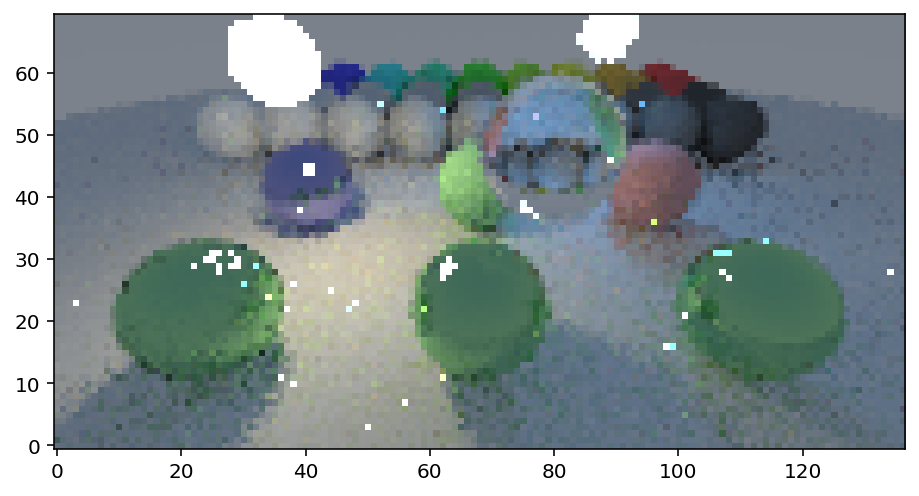

In [25]:
draw(width:551/4, height:283/4, frames:1)

Rays: 1724033


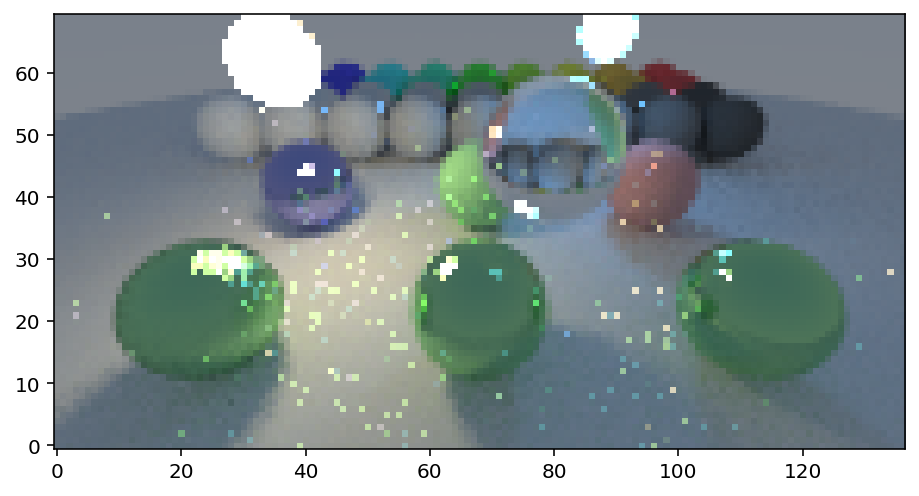

In [26]:
draw(width:551/4, height:283/4, frames:10)

Rays: 17220247


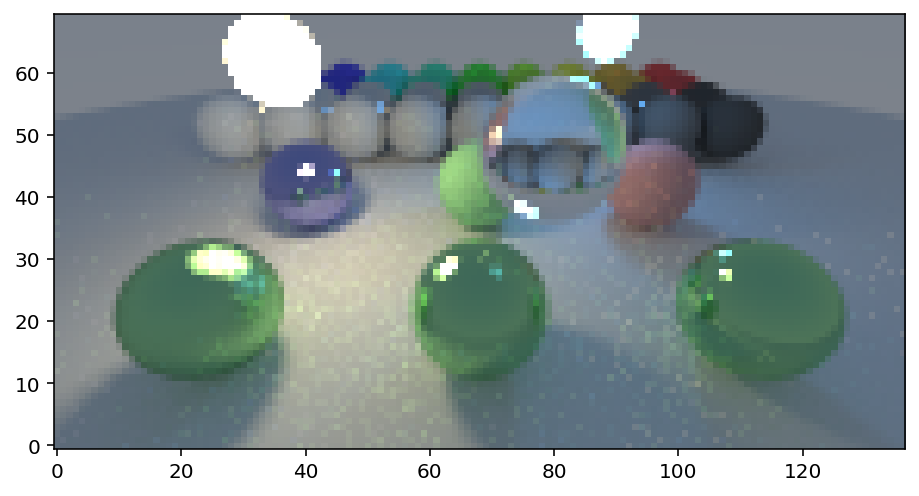

In [27]:
draw(width:551/4, height:283/4, frames:100)

Rays: 172156376


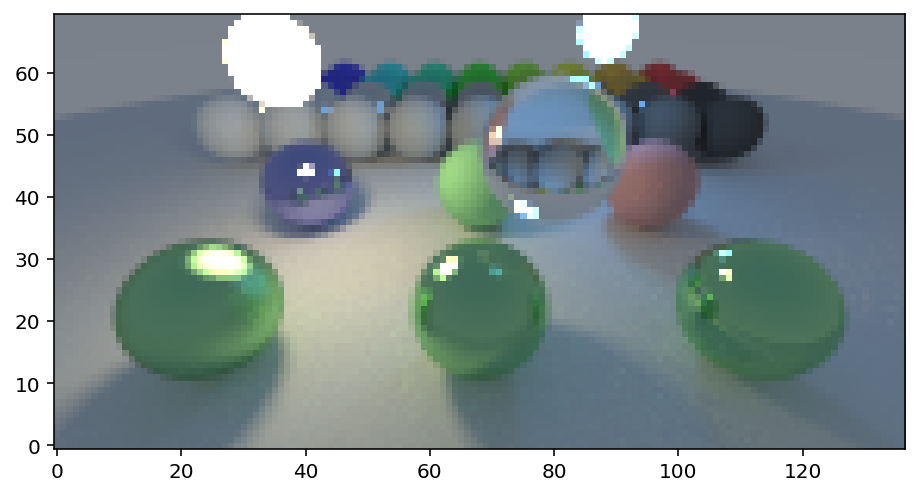

In [28]:
draw(width:551/4, height:283/4, frames:1000)

Reproduce the [github ReadMe image](https://raw.githubusercontent.com/aras-p/ToyPathTracer/master/Shots/screenshot.jpg)

Rays: 8527943


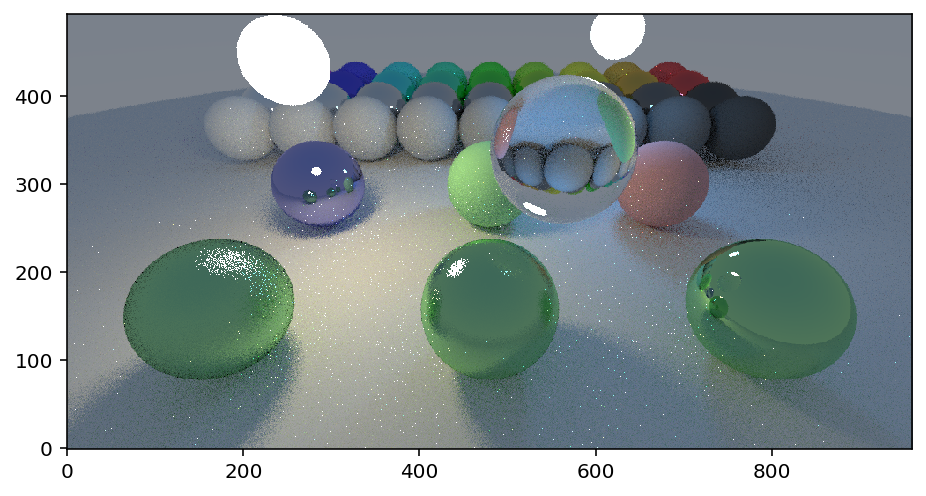

In [29]:
draw(width:960, height:494, frames:1)

Rays: 85288146


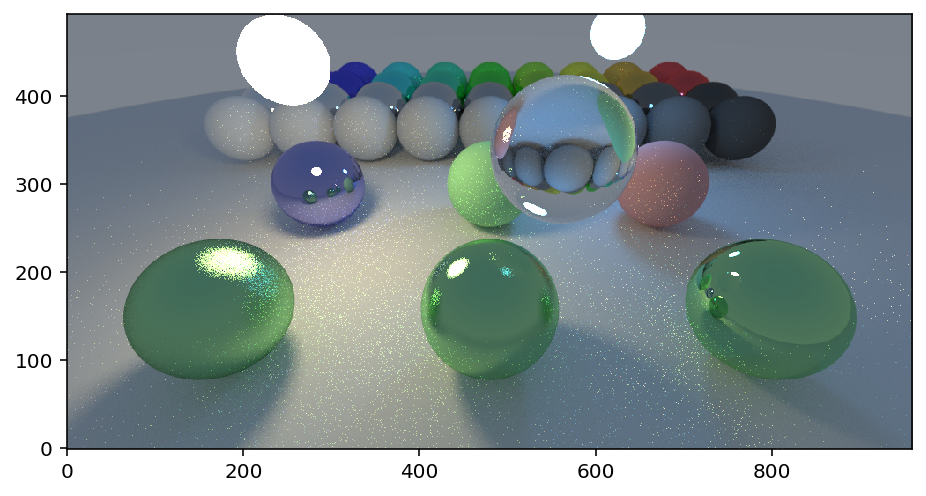

In [30]:
draw(width:960, height:494, frames:10)

Rays: 852842958


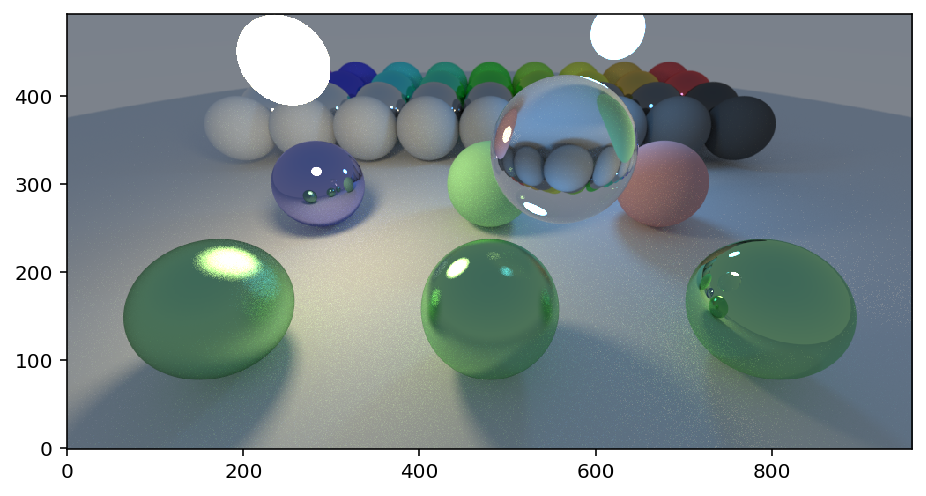

In [31]:
draw(width:960, height:494, frames:100)

In [0]:
draw(width:960, height:494, frames:1000)